In [18]:
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size']=12
import pandas as pd
import os
import sys

In [19]:
workspace = "workspace"
model_name = "test_pst"
exe_name="../../exe/mf6.exe"

nrow = 100
ncol = 100
delc = 1
delr = 1

In [20]:
def model_run(k):
    
    # spatial param
    nlay = 1

    top = 10
    botm = 0

    # packages
    sim = fp.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name, 
                                 sim_ws=workspace)
    tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', 
                                 nper=1, perioddata=[(1.0, 1, 1.0)])
    gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                               model_nam_file='{}.nam'.format(model_name))
    dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,top=top, botm=botm)
    ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")
    ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

    oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                                head_filerecord='{}.hds'.format(model_name),
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('HEAD', 'ALL')])
    

    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)
    rch = fp.mf6.ModflowGwfrcha(gwf,recharge=1/86400/365,save_flows=True)
    
    #bc
    chd = []
    for irow in range(nrow):
        chd.append(((0,irow,0),10))
        chd.append(((0,irow,ncol-1),0))
    chd = fp.mf6.ModflowGwfchd(gwf,pname="chd",filename="bc.chd",maxbound=len(chd),stress_period_data=chd,save_flows=True)
    
    lst_pts = []
    for irow in range(1,nrow-1,7):
        for icol in range(1,ncol-1,7):
            lst_pts.append((0,irow,icol))
            
    obs_lst1=[]
    for pts in lst_pts:
        obs_lst1.append(("0_{}_{}".format(pts[1],pts[2]),"HEAD",pts))

    obs_recarray = {('heads.csv'):obs_lst1}
    obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                          digits=10, print_input=True,
                                          continuous=obs_recarray)
    
    
    sim.write_simulation(silent=True)
    sim.run_simulation()

In [21]:
def gauss(A,sig,x,y,x0=0,y0=0):
    g = A**(-((((x-x0)**2)/(2*sig**2))+((y-y0)**2)/(2*sig**2)))
    return g

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

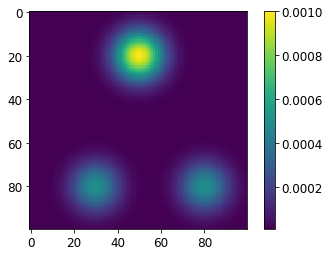

In [22]:
x = np.arange(0,ncol,delr)
y = np.arange(0,nrow,delc)
X,Y = np.meshgrid(x,y)

k = 1e-3*gauss(5,10,X,Y,x0=50,y0=20)
k += 5e-4*gauss(5,10,X,Y,x0=30,y0=80)
k += 5e-4*gauss(5,10,X,Y,x0=80,y0=80)
k[k<1e-5]=1e-5
plt.imshow(k)
plt.colorbar()

filnm = "k.txt"
np.savetxt(os.path.join(workspace,filnm),k)
model_run(filnm)

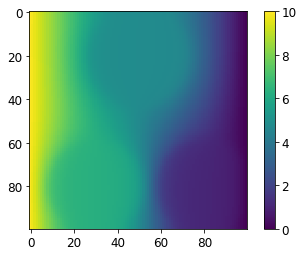

In [23]:
plt.imshow(fp.utils.HeadFile("workspace/{}.hds".format(model_name)).get_data((0,0))[0])
plt.colorbar()

In [24]:
import pyemu
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model(model_name)
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

# empty pst from object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

case = "pest_test"
pf.build_pst("{}.pst".format(case))

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package rch...
    loading package chd...
    loading package obs...
  loading ims package test_pst...
   could not remove start_datetime
2020-07-20 11:43:24.868344 starting: opening PstFrom.log for logging
2020-07-20 11:43:24.868344 starting PstFrom process
2020-07-20 11:43:24.868344 starting: setting up dirs
2020-07-20 11:43:24.873390 starting: removing existing new_d 'template'
2020-07-20 11:43:25.303651 finished: removing existing new_d 'template' took: 0:00:00.430261
2020-07-20 11:43:25.303651 starting: copying original_d 'workspace' to new_d 'template'
2020-07-20 11:43:25.673722 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.370071
2020-07-20 11:43:25.673722 finished: setting up dirs took: 0:00:00.805378
2020-07-20 11:43:25.693349 s

spatial variogram


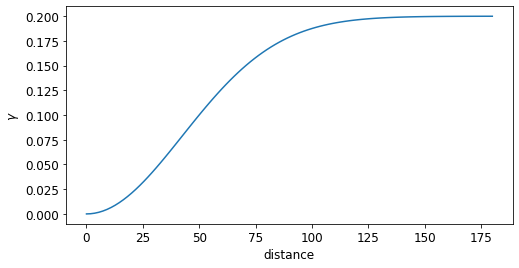

In [35]:
v = pyemu.geostats.GauVario(contribution=0.2,a=60)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

In [26]:
# set an homogeneous k array (as initial value)
k = 1e-4*np.ones([nrow,ncol])
filnm = "k.txt"
np.savetxt(os.path.join(template_ws,filnm),k)

pf.add_parameters(filenames="k.txt",par_type="pilotpoint",pp_space=12,
                   par_name_base="kp",pargp="hp",
                   upper_bound=10.,lower_bound=0.1,ult_ubound=1e-3,ult_lbound=1e-5,geostruct=grid_gs)

2020-07-20 11:43:26.203586 starting: adding pilotpoint type multiplier style parameters for file(s) ['k.txt']
2020-07-20 11:43:26.203586 starting: loading array template\k.txt
2020-07-20 11:43:26.243707 finished: loading array template\k.txt took: 0:00:00.040121
2020-07-20 11:43:26.243707 loaded array 'k.txt' of shape (100, 100)
2020-07-20 11:43:26.293574 starting: writing array-based template file 'kp_inst0_pilotpoint.csv.tpl'
2020-07-20 11:43:26.293574 starting: setting up pilot point parameters
2020-07-20 11:43:26.303502 No spatial reference (containing cell spacing) passed.
2020-07-20 11:43:26.303502 OK - using spatial reference in parent object.
ibound not passed, using array of ones
2020-07-20 11:43:26.563695 64 pilot point parameters created
2020-07-20 11:43:26.563695 pilot point 'pargp':kp_inst:0
2020-07-20 11:43:26.563695 finished: setting up pilot point parameters took: 0:00:00.270121
2020-07-20 11:43:26.583473 starting: calculating factors for pargp=kp_inst:0
2020-07-20 11:4

In [27]:
# add run model command
pf.mod_sys_cmds.append("..\mf6")
pf.build_pst("{}.pst".format(case))

#Rewrite ins file because Pyemu isn't smart enough

file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

noptmax:30, npar_adj:64, nnz_obs:196
2020-07-20 11:44:09.745467 forward_run line:pyemu.os_utils.run(r'..\mf6')



noptmax:30, npar_adj:64, nnz_obs:196
2020-07-20 11:44:09.977287 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...
2020-07-20 11:44:09.999430 starting: building prior covariance matrix
2020-07-20 11:44:10.262591 saving prior covariance matrix to file template\pest_test.prior.cov
2020-07-20 11:44:10.300351 finished: building prior covariance matrix took: 0:00:00.300921


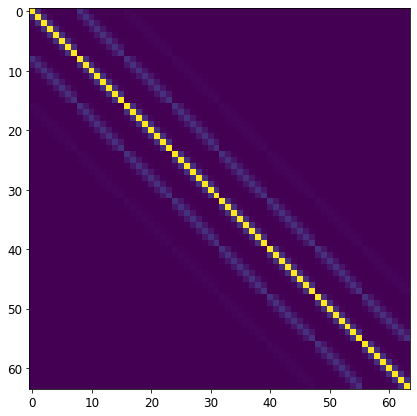

In [28]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

In [29]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:-1, npar_adj:64, nnz_obs:196


In [30]:
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=6,worker_root=".",master_dir=m_d)